<h2> Initialization </h2>

In [1]:

import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import os
import csv
import pandas as pd
import math

from skimage.io import imread
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from matplotlib import image
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator

from matplotlib import image

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import random
print("Tensorflow version %s" %tf.__version__)


device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
if  tf.test.is_gpu_available():
    device_str = "/device:GPU:0"
else:
    device_str = "/cpu:0"

folders=["/BENIGN/benign_","/CANCER/cancer_"]#,"/NORMAL(PNG)/normal_"]
directory=r'Z:/Dataset/NN_Dataset/DDSM/DDSM_Resized/CrossVal'
case=""
left_cc=""
left_mlo=""
right_cc=""
right_mlo=""
lb=0
lm=0
rb=0
rm=0

in_channel=3
img_rows, img_cols=512, 384

AUTOTUNE = tf.data.experimental.AUTOTUNE

training="training"
test="test"
validation="validation"

img_size=300
epoch=20
regl2 = 0.0001
lr=0.0001
for_step=15

Using TensorFlow backend.


Tensorflow version 2.0.0
Found GPU at: /device:GPU:0


<h2> Cross Val CSVs Generation - done only once </h2>

In [2]:
numbers= ['01/','02/','03/','04/','05/','06/','07/','08/','09/','10/']
numbersCV =[]



def createCrossVal():
    #select 5 couples of validationSets
    N = ['01/','02/','03/','04/','05/','06/','07/','08/','09/','10/']
    
    R=0
    while R<5:
        random.shuffle(N)
        first = random.choice(numbers)
        numbers.remove(first)
        second = random.choice(numbers)
        numbers.remove(second)
       
        tmp = []
        
        for e in N:
            if e == first or e == second:
                continue
            tmp.append(e)
        if len(tmp)==8:
            tmp.append(first)
            tmp.append(second)
            numbersCV.append(tmp)
            
        R=R+1
    return

createCrossVal()
print(numbersCV)
numbers1 = numbersCV[4]
numbers1 = numbers1[0:8]
numbers2= numbersCV[4]
numbers2 = numbers2[8:10]
folders=["/BENIGN(PNG)/benign_","/CANCER(PNG)/cancer_"]
directory2=r'Z:/Dataset/NN_Dataset/DDSM/DDSM_Resized'

[['08/', '06/', '02/', '10/', '03/', '09/', '05/', '04/', '07/', '01/'], ['10/', '01/', '08/', '05/', '04/', '06/', '07/', '02/', '09/', '03/'], ['08/', '10/', '02/', '01/', '04/', '07/', '09/', '03/', '05/', '06/'], ['07/', '05/', '02/', '01/', '03/', '06/', '09/', '08/', '04/', '10/'], ['07/', '06/', '03/', '10/', '05/', '09/', '04/', '01/', '08/', '02/']]


<h3 style="color:blue"> CROSS VAL 1/5</h3>

In [2]:
col=["case","left_cc","left_mlo","right_cc","right_mlo","lb","lm","rb","rm"]
dtypes={"case": "str","left_cc": "str","left_mlo": "str","right_cc": "str","right_mlo": "str","lb": "int","lm": "int","rb": "int","rm": "int"}
df_training=pd.read_csv(directory+'/training_1.csv', sep=',', names=col,dtype=dtypes,  header=None)
df_validation=pd.read_csv(directory+'/validation_1.csv', sep=',', names=col,dtype=dtypes,  header=None)
#df_test=pd.read_csv(directory+'/test_r.csv', sep=',', names=col,dtype=dtypes,  header=None)

def read_spectograms(file_paths, img_rows, img_cols, channels):

  images = []
  
  for file_path in file_paths:
    if file_path=="nan":
        continue
    images.append(imread(file_path))
  
  images = np.asarray(images, dtype=np.float32)
  
  # normalize
  images = images / 255
  
  # reshape to match Keras expectaions
  images = images.reshape(images.shape[0], img_rows, img_cols, channels)

  return images


x_train_left_mlo = read_spectograms(df_training.left_mlo.values, img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values, img_rows, img_cols, in_channel)

###Right

x_train_right_mlo = read_spectograms(df_training.right_mlo.values, img_rows, img_cols, in_channel)
x_train_right_cc= read_spectograms(df_training.right_cc.values, img_rows, img_cols, in_channel)

###labels

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
labels = df_training[["lb","lm","rb","rm"]].reset_index(drop=True)
#labels=labels.values
labels
print(type(labels))

x_validation_left_mlo = read_spectograms(df_validation.left_mlo.values, img_rows, img_cols, in_channel)
x_validation_left_cc= read_spectograms(df_validation.left_cc.values, img_rows, img_cols, in_channel)

x_validation_right_mlo = read_spectograms(df_validation.right_mlo.values, img_rows, img_cols, in_channel)
x_validation_right_cc= read_spectograms(df_validation.right_cc.values, img_rows, img_cols, in_channel)


mlb = MultiLabelBinarizer()
labels_validation = df_validation[["lb","lm","rb","rm"]].reset_index(drop=True)
#labels_validation=labels_validation.values
labels_validation
print(type(labels_validation))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [3]:
#  V 2

def resnetBlock(inputimage,k=2,striede=1, name=""):

  batch_normalize = keras.layers.BatchNormalization( axis=-1,name="")(inputimage)


  activation=keras.activations.relu(batch_normalize )

  conv3x3_1=tf.keras.layers.Conv2D(
    filters=k,
    strides=striede,
    kernel_size=(3,3),
    name="",
  padding="same"
  )(activation)

  conv1x1_1=tf.keras.layers.Conv2D(
    filters=k,
    strides=striede,
    kernel_size=(1,1),
    name="",
#    activation=keras.activations.relu
  )(activation)


  batch_normalize_2 = keras.layers.BatchNormalization( axis=-1,name="")(conv3x3_1)

  activation2=keras.activations.relu(batch_normalize_2 )
  conv3x3_1=tf.keras.layers.Conv2D(
    filters=k,
    kernel_size=(3,3),
    name="",
    padding="same"
  )(activation2)

  outputs=keras.layers.Add()([conv3x3_1,conv1x1_1])
  return outputs


def resNetLayers(inputimage,name=""):
  block1=resnetBlock(inputimage,k=16,name="block1")
  #block2=resnetBlock(block1,k=16,name="block2")
  block3=resnetBlock(block1,k=16,striede=2,name="block3")
  #block4=resnetBlock(block3,k=32,name="block4")
  block5=resnetBlock(block3,k=32,striede=2,name="block5")
  pool=keras.layers.AveragePooling2D(
      pool_size=(3,3), strides=2, padding='same', name='' #(3,3)
  )(block5)
  #block6=resnetBlock(block5,k=32,striede=2,name="block6")
  block7=resnetBlock(pool,k=32,striede=2,name="block7")
  #block8=resnetBlock(inputfilter=128,k=128,name="block8")(block7)
  
  #block10=resnetBlock(inputfilter=256,k=256,name="block10")(block9)
  return block7

def singleViewResnet(inputimage, name=""):

  conv7x7=tf.keras.layers.Conv2D(
    filters=16,
    strides=2,
    kernel_size=(5,5),
    name="",
    activation=keras.activations.relu
  )(inputimage)

  pool3x3=keras.layers.AveragePooling2D(
      pool_size=(2,2), strides=2, padding='same', name='' #(3,3)
  )(conv7x7)

  resNetL=resNetLayers(pool3x3,name="")
  print(resNetL.shape)
  batch_normalize = keras.layers.BatchNormalization( axis=-1,name="")(resNetL)

  relu=keras.activations.relu(batch_normalize)
  
  return relu


def view_wise(img_rows=300, img_cols=300):
  left_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_cc")
  right_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_cc"
  )  

  left_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_mlo"
  )  
  right_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_mlo"
  )

  #cc_resnet=singleViewResnet(name="cc_resnet")
  #mlo_resnet=singleViewResnet(name="mlo_resnet")

  cc_resnet_left=singleViewResnet(left_cc_input)
  cc_resnet_right=singleViewResnet(right_cc_input)

  mlo_resnet_left=singleViewResnet(left_mlo_input)
  mlo_resent_right=singleViewResnet(right_mlo_input)

  avg_pool_cc_left=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(cc_resnet_left)
  avg_pool_cc_right=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(cc_resnet_right)

  avg_pool_mlo_left=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(mlo_resnet_left)
  avg_pool_mlo_right=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(mlo_resent_right)

  mlo=keras.layers.Concatenate(axis=-1)([avg_pool_mlo_left, avg_pool_mlo_right])
  cc=keras.layers.Concatenate(axis=-1)([avg_pool_cc_left, avg_pool_cc_right])

  mlo_flatten=tf.keras.layers.Flatten()(mlo)
  cc_flatten=tf.keras.layers.Flatten()(cc)

  """
  mlo_dense1=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.Dense(256,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(mlo_flatten)
    )
  """
  mlo_dense1=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(2048,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(mlo_flatten)
        )
      )
  mlo_dense3=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(1024,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(mlo_dense1)
        )
      ) 
  
  mlo_dense2=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(mlo_dense3)
    )
  
  """
  cc_dense1=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.Dense(512,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(cc_flatten)
    )
  """
  

  cc_dense1=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(2048,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(cc_flatten)
        )
      )
  cc_dense3=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(1024,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(cc_dense1)
        )
      ) 
 
  cc_dense2=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(cc_dense3)
    )
  
  
  
  """mlo_rb=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="mlo_rb")(mlo_dense2)
  mlo_rm=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="mlo_rm")(mlo_dense2)
  mlo_lb=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="mlo_lb")(mlo_dense2)
  mlo_lm=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="mlo_lm")(mlo_dense2)
  
  cc_rb=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="cc_rb")(cc_dense2)
  cc_rm=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="cc_rm")(cc_dense2)
  cc_lb=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="cc_lb")(cc_dense2)
  cc_lm=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="cc_lm")(cc_dense2)
  
  rb_output = keras.layers.Average(name="rb")([mlo_rb,cc_rb])
  rm_output = keras.layers.Average(name="rm")([mlo_rm,cc_rm])
  lb_output = keras.layers.Average(name="lb")([mlo_lb,cc_lb])
  lm_output = keras.layers.Average(name="lm")([mlo_lm,cc_lm])"""

  output=keras.layers.Average(name="outpu")([cc_dense2,mlo_dense2])

  output=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(output)
    )
  
 
  output=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(4,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(output)
    )

  return keras.Model(
      inputs=[left_cc_input, right_cc_input, left_mlo_input, right_mlo_input],
      outputs=output,name="view-wise"
  )
model=view_wise(img_rows, img_cols)
model.summary()
#keras.utils.plot_model(model, "/gdrive/My Drive/Colab_Notebooks/NNPROJECT/image_Net/view-wise.png", show_shapes=True, expand_nested=False)




(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
Model: "view-wise"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_cc (InputLayer)            [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
right_cc (InputLayer)           [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
left_mlo (InputLayer)           [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
right_mlo (InputLayer)          [(None, 512, 384, 3) 0                                            
______________________

In [4]:
batch_size=32
step_per_epoch=len(x_train_left_mlo)/batch_size

cbks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss"),
        tf.keras.callbacks.ModelCheckpoint(
                    "Z:\\Dataset\\NN_Dataset\\DDSM\\Cachelorenzo\\checkpoint_auc1",
                    monitor="val_auc",
                    mode='max',
                    verbose=1,
                    save_best_only=True,
                   
                    
                    save_freq="epoch"
                    
        ),
       tf.keras.callbacks.ModelCheckpoint(
                    "Z:\\Dataset\\NN_Dataset\\DDSM\\Cachelorenzo\\checkpoint_loss1",
                    monitor="val_loss",
                    
                    verbose=1,
                    save_best_only=True,
                   
                    
                    save_freq="epoch"
       )]

model.compile(#optimizer=keras.optimizers.Adam(lr=0.001),
              #optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07),
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history=model.fit(x={"left_mlo": x_train_left_mlo,
                         "left_cc": x_train_left_cc,
                         "right_mlo":x_train_right_mlo,
                         "right_cc":x_train_right_cc},
                  y=labels.values,
                  epochs=50,verbose=1,
                  callbacks = cbks,
                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "left_cc": x_validation_left_cc,
                         "right_mlo":x_validation_right_mlo,
                         "right_cc":x_validation_right_cc},
                    labels_validation.values
                  ))

"""y={"lb":labels["lb"],
    "lm":labels["lm"],
    "rm":labels["rm"],
    "rb":labels["rb"]}
    
"""

Train on 978 samples, validate on 268 samples
Epoch 1/50
960/978 [============================>.] - ETA: 0s - loss: 1.1120 - auc: 0.5040 - binary_accuracy: 0.7099
Epoch 00001: val_auc improved from -inf to 0.50760, saving model to Z:\Dataset\NN_Dataset\DDSM\Cachelorenzo\checkpoint_auc1
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Z:\Dataset\NN_Dataset\DDSM\Cachelorenzo\checkpoint_auc1\assets

Epoch 00001: val_loss improved from inf to 1.06210, saving model to Z:\Dataset\NN_Dataset\DDSM\Cachelorenzo\checkpoint_loss1
INFO:tensorflow:Assets written to: Z:\Dataset\NN_Dataset\DDSM\Cachelorenzo\checkpoint_loss1\assets
978/978 [==============================] - 89s 91ms/sample - loss: 1.1112 - auc: 0.5028 - binary_accuracy: 0.7104 - val_loss: 1.0621 - val_auc: 0.5076 - val_binary_accuracy: 0.7220
Epoch 2/50
960/978 [============================>.] - ETA: 0s - loss: 1.0065 - auc: 0.5262 - binary_accuracy: 0.7367
Epoch 00002

'y={"lb":labels["lb"],\n    "lm":labels["lm"],\n    "rm":labels["rm"],\n    "rb":labels["rb"]}\n    \n'

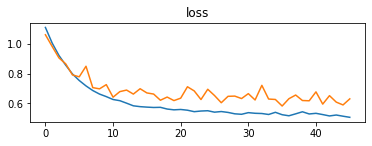

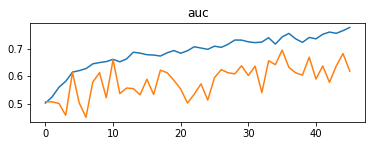

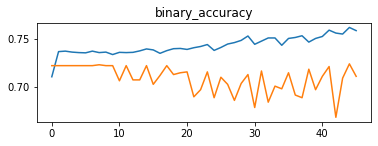

In [7]:
for i in history.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history.history[i], label='train')
  pyplot.plot(history.history['val_'+i], label='test')
  pyplot.show()


<h3 style="color:blue"> CROSS VAL 2/5 </h3>

In [2]:
col=["case","left_cc","left_mlo","right_cc","right_mlo","lb","lm","rb","rm"]
dtypes={"case": "str","left_cc": "str","left_mlo": "str","right_cc": "str","right_mlo": "str","lb": "int","lm": "int","rb": "int","rm": "int"}
df_training=pd.read_csv(directory+'/training_2.csv', sep=',', names=col,dtype=dtypes,  header=None)
df_validation=pd.read_csv(directory+'/validation_2.csv', sep=',', names=col,dtype=dtypes,  header=None)
#df_test=pd.read_csv(directory+'/test_r.csv', sep=',', names=col,dtype=dtypes,  header=None)

def read_spectograms(file_paths, img_rows, img_cols, channels):

  images = []
  
  for file_path in file_paths:
    if file_path=="nan":
        continue
    images.append(imread(file_path))
  
  images = np.asarray(images, dtype=np.float32)
  
  # normalize
  images = images / 255
  
  # reshape to match Keras expectaions
  images = images.reshape(images.shape[0], img_rows, img_cols, channels)

  return images


x_train_left_mlo = read_spectograms(df_training.left_mlo.values, img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values, img_rows, img_cols, in_channel)

###Right

x_train_right_mlo = read_spectograms(df_training.right_mlo.values, img_rows, img_cols, in_channel)
x_train_right_cc= read_spectograms(df_training.right_cc.values, img_rows, img_cols, in_channel)

###labels

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
labels = df_training[["lb","lm","rb","rm"]].reset_index(drop=True)
#labels=labels.values
labels
print(type(labels))

x_validation_left_mlo = read_spectograms(df_validation.left_mlo.values, img_rows, img_cols, in_channel)
x_validation_left_cc= read_spectograms(df_validation.left_cc.values, img_rows, img_cols, in_channel)

x_validation_right_mlo = read_spectograms(df_validation.right_mlo.values, img_rows, img_cols, in_channel)
x_validation_right_cc= read_spectograms(df_validation.right_cc.values, img_rows, img_cols, in_channel)


mlb = MultiLabelBinarizer()
labels_validation = df_validation[["lb","lm","rb","rm"]].reset_index(drop=True)
#labels_validation=labels_validation.values
labels_validation
print(type(labels_validation))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [3]:
#  V 2

def resnetBlock(inputimage,k=2,striede=1, name=""):

  batch_normalize = keras.layers.BatchNormalization( axis=-1,name="")(inputimage)


  activation=keras.activations.relu(batch_normalize )

  conv3x3_1=tf.keras.layers.Conv2D(
    filters=k,
    strides=striede,
    kernel_size=(3,3),
    name="",
  padding="same"
  )(activation)

  conv1x1_1=tf.keras.layers.Conv2D(
    filters=k,
    strides=striede,
    kernel_size=(1,1),
    name="",
#    activation=keras.activations.relu
  )(activation)


  batch_normalize_2 = keras.layers.BatchNormalization( axis=-1,name="")(conv3x3_1)

  activation2=keras.activations.relu(batch_normalize_2 )
  conv3x3_1=tf.keras.layers.Conv2D(
    filters=k,
    kernel_size=(3,3),
    name="",
    padding="same"
  )(activation2)

  outputs=keras.layers.Add()([conv3x3_1,conv1x1_1])
  return outputs


def resNetLayers(inputimage,name=""):
  block1=resnetBlock(inputimage,k=16,name="block1")
  #block2=resnetBlock(block1,k=16,name="block2")
  block3=resnetBlock(block1,k=16,striede=2,name="block3")
  #block4=resnetBlock(block3,k=32,name="block4")
  block5=resnetBlock(block3,k=32,striede=2,name="block5")
  pool=keras.layers.AveragePooling2D(
      pool_size=(3,3), strides=2, padding='same', name='' #(3,3)
  )(block5)
  #block6=resnetBlock(block5,k=32,striede=2,name="block6")
  block7=resnetBlock(pool,k=32,striede=2,name="block7")
  #block8=resnetBlock(inputfilter=128,k=128,name="block8")(block7)
  
  #block10=resnetBlock(inputfilter=256,k=256,name="block10")(block9)
  return block7

def singleViewResnet(inputimage, name=""):

  conv7x7=tf.keras.layers.Conv2D(
    filters=16,
    strides=2,
    kernel_size=(5,5),
    name="",
    activation=keras.activations.relu
  )(inputimage)

  pool3x3=keras.layers.AveragePooling2D(
      pool_size=(2,2), strides=2, padding='same', name='' #(3,3)
  )(conv7x7)

  resNetL=resNetLayers(pool3x3,name="")
  print(resNetL.shape)
  batch_normalize = keras.layers.BatchNormalization( axis=-1,name="")(resNetL)

  relu=keras.activations.relu(batch_normalize)
  
  return relu


def view_wise(img_rows=300, img_cols=300):
  left_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_cc")
  right_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_cc"
  )  

  left_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_mlo"
  )  
  right_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_mlo"
  )

  #cc_resnet=singleViewResnet(name="cc_resnet")
  #mlo_resnet=singleViewResnet(name="mlo_resnet")

  cc_resnet_left=singleViewResnet(left_cc_input)
  cc_resnet_right=singleViewResnet(right_cc_input)

  mlo_resnet_left=singleViewResnet(left_mlo_input)
  mlo_resent_right=singleViewResnet(right_mlo_input)

  avg_pool_cc_left=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(cc_resnet_left)
  avg_pool_cc_right=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(cc_resnet_right)

  avg_pool_mlo_left=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(mlo_resnet_left)
  avg_pool_mlo_right=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(mlo_resent_right)

  mlo=keras.layers.Concatenate(axis=-1)([avg_pool_mlo_left, avg_pool_mlo_right])
  cc=keras.layers.Concatenate(axis=-1)([avg_pool_cc_left, avg_pool_cc_right])

  mlo_flatten=tf.keras.layers.Flatten()(mlo)
  cc_flatten=tf.keras.layers.Flatten()(cc)

  """
  mlo_dense1=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.Dense(256,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(mlo_flatten)
    )
  """
  mlo_dense1=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(2048,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(mlo_flatten)
        )
      )
  mlo_dense3=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(1024,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(mlo_dense1)
        )
      ) 
  
  mlo_dense2=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(mlo_dense3)
    )
  
  """
  cc_dense1=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.Dense(512,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(cc_flatten)
    )
  """
  

  cc_dense1=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(2048,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(cc_flatten)
        )
      )
  cc_dense3=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(1024,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(cc_dense1)
        )
      ) 
 
  cc_dense2=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(cc_dense3)
    )
  
  
  
  """mlo_rb=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="mlo_rb")(mlo_dense2)
  mlo_rm=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="mlo_rm")(mlo_dense2)
  mlo_lb=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="mlo_lb")(mlo_dense2)
  mlo_lm=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="mlo_lm")(mlo_dense2)
  
  cc_rb=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="cc_rb")(cc_dense2)
  cc_rm=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="cc_rm")(cc_dense2)
  cc_lb=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="cc_lb")(cc_dense2)
  cc_lm=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="cc_lm")(cc_dense2)
  
  rb_output = keras.layers.Average(name="rb")([mlo_rb,cc_rb])
  rm_output = keras.layers.Average(name="rm")([mlo_rm,cc_rm])
  lb_output = keras.layers.Average(name="lb")([mlo_lb,cc_lb])
  lm_output = keras.layers.Average(name="lm")([mlo_lm,cc_lm])"""

  output=keras.layers.Average(name="outpu")([cc_dense2,mlo_dense2])

  output=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(output)
    )
  
 
  output=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(4,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(output)
    )

  return keras.Model(
      inputs=[left_cc_input, right_cc_input, left_mlo_input, right_mlo_input],
      outputs=output,name="view-wise"
  )
model=view_wise(img_rows, img_cols)
#model.summary()
#keras.utils.plot_model(model, "/gdrive/My Drive/Colab_Notebooks/NNPROJECT/image_Net/view-wise.png", show_shapes=True, expand_nested=False)




(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)


In [4]:
batch_size=32
step_per_epoch=len(x_train_left_mlo)/batch_size

cbks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss"),
        tf.keras.callbacks.ModelCheckpoint(
                    "Z:\\Dataset\\NN_Dataset\\DDSM\\Cachelorenzo\\checkpoint_auc2",
                    monitor="val_auc",
                    mode="max",
                    verbose=1,
                    save_best_only=True,
                   
                    
                    save_freq="epoch"
                    
        ),
       tf.keras.callbacks.ModelCheckpoint(
                    "Z:\\Dataset\\NN_Dataset\\DDSM\\Cachelorenzo\\checkpoint_loss2",
                    monitor="val_loss",
                    
                    verbose=1,
                    save_best_only=True,
                   
                    
                    save_freq="epoch"
       )]

model.compile(#optimizer=keras.optimizers.Adam(lr=0.001),
              #optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07),
              loss=keras.losses.BinaryCrossentropy(),
              callbacks = cbks,
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history=model.fit(x={"left_mlo": x_train_left_mlo,
                         "left_cc": x_train_left_cc,
                         "right_mlo":x_train_right_mlo,
                         "right_cc":x_train_right_cc},
                  y=labels.values,
                  epochs=30,verbose=1,

                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "left_cc": x_validation_left_cc,
                         "right_mlo":x_validation_right_mlo,
                         "right_cc":x_validation_right_cc},
                    labels_validation.values
                  ))

"""y={"lb":labels["lb"],
    "lm":labels["lm"],
    "rm":labels["rm"],
    "rb":labels["rb"]}
    
"""

Train on 1009 samples, validate on 237 samples
Epoch 1/30
1009/1009 [==============================] - 62s 62ms/sample - loss: 1.1172 - auc: 0.5117 - binary_accuracy: 0.7054 - val_loss: 1.0344 - val_auc: 0.5138 - val_binary_accuracy: 0.7426
Epoch 2/30
1009/1009 [==============================] - 28s 27ms/sample - loss: 1.0128 - auc: 0.4958 - binary_accuracy: 0.7317 - val_loss: 0.9460 - val_auc: 0.5682 - val_binary_accuracy: 0.7426
Epoch 3/30
1009/1009 [==============================] - 25s 24ms/sample - loss: 0.9319 - auc: 0.5036 - binary_accuracy: 0.7319 - val_loss: 0.8804 - val_auc: 0.5055 - val_binary_accuracy: 0.7426
Epoch 4/30
1009/1009 [==============================] - 22s 22ms/sample - loss: 0.8654 - auc: 0.5104 - binary_accuracy: 0.7319 - val_loss: 0.8200 - val_auc: 0.5149 - val_binary_accuracy: 0.7426
Epoch 5/30
1009/1009 [==============================] - 22s 21ms/sample - loss: 0.8146 - auc: 0.5007 - binary_accuracy: 0.7322 - val_loss: 0.7747 - val_auc: 0.5046 - val_binary_

'y={"lb":labels["lb"],\n    "lm":labels["lm"],\n    "rm":labels["rm"],\n    "rb":labels["rb"]}\n    \n'

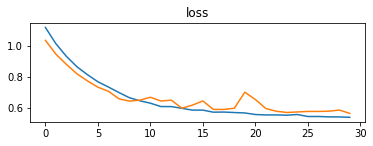

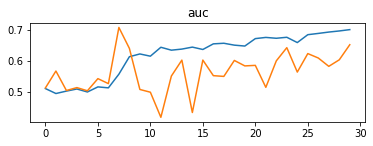

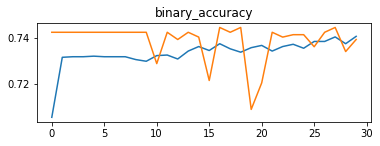

In [5]:
for i in history.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history.history[i], label='train')
  pyplot.plot(history.history['val_'+i], label='test')
  pyplot.show()


<h3 style="color:blue"> CROSS VAL 3/5 </h3>

In [2]:
col=["case","left_cc","left_mlo","right_cc","right_mlo","lb","lm","rb","rm"]
dtypes={"case": "str","left_cc": "str","left_mlo": "str","right_cc": "str","right_mlo": "str","lb": "int","lm": "int","rb": "int","rm": "int"}
df_training=pd.read_csv(directory+'/training_3.csv', sep=',', names=col,dtype=dtypes,  header=None)
df_validation=pd.read_csv(directory+'/validation_3.csv', sep=',', names=col,dtype=dtypes,  header=None)
#df_test=pd.read_csv(directory+'/test_r.csv', sep=',', names=col,dtype=dtypes,  header=None)

def read_spectograms(file_paths, img_rows, img_cols, channels):

  images = []
  
  for file_path in file_paths:
    if file_path=="nan":
        continue
    images.append(imread(file_path))
  
  images = np.asarray(images, dtype=np.float32)
  
  # normalize
  images = images / 255
  
  # reshape to match Keras expectaions
  images = images.reshape(images.shape[0], img_rows, img_cols, channels)

  return images


x_train_left_mlo = read_spectograms(df_training.left_mlo.values, img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values, img_rows, img_cols, in_channel)

###Right

x_train_right_mlo = read_spectograms(df_training.right_mlo.values, img_rows, img_cols, in_channel)
x_train_right_cc= read_spectograms(df_training.right_cc.values, img_rows, img_cols, in_channel)

###labels

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
labels = df_training[["lb","lm","rb","rm"]].reset_index(drop=True)
#labels=labels.values
labels
print(type(labels))

x_validation_left_mlo = read_spectograms(df_validation.left_mlo.values, img_rows, img_cols, in_channel)
x_validation_left_cc= read_spectograms(df_validation.left_cc.values, img_rows, img_cols, in_channel)

x_validation_right_mlo = read_spectograms(df_validation.right_mlo.values, img_rows, img_cols, in_channel)
x_validation_right_cc= read_spectograms(df_validation.right_cc.values, img_rows, img_cols, in_channel)


mlb = MultiLabelBinarizer()
labels_validation = df_validation[["lb","lm","rb","rm"]].reset_index(drop=True)
#labels_validation=labels_validation.values
labels_validation
print(type(labels_validation))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [3]:
#  V 2

def resnetBlock(inputimage,k=2,striede=1, name=""):

  batch_normalize = keras.layers.BatchNormalization( axis=-1,name="")(inputimage)


  activation=keras.activations.relu(batch_normalize )

  conv3x3_1=tf.keras.layers.Conv2D(
    filters=k,
    strides=striede,
    kernel_size=(3,3),
    name="",
  padding="same"
  )(activation)

  conv1x1_1=tf.keras.layers.Conv2D(
    filters=k,
    strides=striede,
    kernel_size=(1,1),
    name="",
#    activation=keras.activations.relu
  )(activation)


  batch_normalize_2 = keras.layers.BatchNormalization( axis=-1,name="")(conv3x3_1)

  activation2=keras.activations.relu(batch_normalize_2 )
  conv3x3_1=tf.keras.layers.Conv2D(
    filters=k,
    kernel_size=(3,3),
    name="",
    padding="same"
  )(activation2)

  outputs=keras.layers.Add()([conv3x3_1,conv1x1_1])
  return outputs


def resNetLayers(inputimage,name=""):
  block1=resnetBlock(inputimage,k=16,name="block1")
  #block2=resnetBlock(block1,k=16,name="block2")
  block3=resnetBlock(block1,k=16,striede=2,name="block3")
  #block4=resnetBlock(block3,k=32,name="block4")
  block5=resnetBlock(block3,k=32,striede=2,name="block5")
  pool=keras.layers.AveragePooling2D(
      pool_size=(3,3), strides=2, padding='same', name='' #(3,3)
  )(block5)
  #block6=resnetBlock(block5,k=32,striede=2,name="block6")
  block7=resnetBlock(pool,k=32,striede=2,name="block7")
  #block8=resnetBlock(inputfilter=128,k=128,name="block8")(block7)
  
  #block10=resnetBlock(inputfilter=256,k=256,name="block10")(block9)
  return block7

def singleViewResnet(inputimage, name=""):

  conv7x7=tf.keras.layers.Conv2D(
    filters=16,
    strides=2,
    kernel_size=(5,5),
    name="",
    activation=keras.activations.relu
  )(inputimage)

  pool3x3=keras.layers.AveragePooling2D(
      pool_size=(2,2), strides=2, padding='same', name='' #(3,3)
  )(conv7x7)

  resNetL=resNetLayers(pool3x3,name="")
  print(resNetL.shape)
  batch_normalize = keras.layers.BatchNormalization( axis=-1,name="")(resNetL)

  relu=keras.activations.relu(batch_normalize)
  
  return relu


def view_wise(img_rows=300, img_cols=300):
  left_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_cc")
  right_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_cc"
  )  

  left_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_mlo"
  )  
  right_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_mlo"
  )

  #cc_resnet=singleViewResnet(name="cc_resnet")
  #mlo_resnet=singleViewResnet(name="mlo_resnet")

  cc_resnet_left=singleViewResnet(left_cc_input)
  cc_resnet_right=singleViewResnet(right_cc_input)

  mlo_resnet_left=singleViewResnet(left_mlo_input)
  mlo_resent_right=singleViewResnet(right_mlo_input)

  avg_pool_cc_left=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(cc_resnet_left)
  avg_pool_cc_right=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(cc_resnet_right)

  avg_pool_mlo_left=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(mlo_resnet_left)
  avg_pool_mlo_right=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(mlo_resent_right)

  mlo=keras.layers.Concatenate(axis=-1)([avg_pool_mlo_left, avg_pool_mlo_right])
  cc=keras.layers.Concatenate(axis=-1)([avg_pool_cc_left, avg_pool_cc_right])

  mlo_flatten=tf.keras.layers.Flatten()(mlo)
  cc_flatten=tf.keras.layers.Flatten()(cc)

  """
  mlo_dense1=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.Dense(256,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(mlo_flatten)
    )
  """
  mlo_dense1=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(2048,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(mlo_flatten)
        )
      )
  mlo_dense3=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(1024,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(mlo_dense1)
        )
      ) 
  
  mlo_dense2=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(mlo_dense3)
    )
  
  """
  cc_dense1=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.Dense(512,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(cc_flatten)
    )
  """
  

  cc_dense1=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(2048,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(cc_flatten)
        )
      )
  cc_dense3=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(1024,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(cc_dense1)
        )
      ) 
 
  cc_dense2=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(cc_dense3)
    )
  
  
  
  """mlo_rb=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="mlo_rb")(mlo_dense2)
  mlo_rm=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="mlo_rm")(mlo_dense2)
  mlo_lb=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="mlo_lb")(mlo_dense2)
  mlo_lm=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="mlo_lm")(mlo_dense2)
  
  cc_rb=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="cc_rb")(cc_dense2)
  cc_rm=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="cc_rm")(cc_dense2)
  cc_lb=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="cc_lb")(cc_dense2)
  cc_lm=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="cc_lm")(cc_dense2)
  
  rb_output = keras.layers.Average(name="rb")([mlo_rb,cc_rb])
  rm_output = keras.layers.Average(name="rm")([mlo_rm,cc_rm])
  lb_output = keras.layers.Average(name="lb")([mlo_lb,cc_lb])
  lm_output = keras.layers.Average(name="lm")([mlo_lm,cc_lm])"""

  output=keras.layers.Average(name="outpu")([cc_dense2,mlo_dense2])

  output=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(output)
    )
  
 
  output=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(4,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(output)
    )

  return keras.Model(
      inputs=[left_cc_input, right_cc_input, left_mlo_input, right_mlo_input],
      outputs=output,name="view-wise"
  )
model=view_wise(img_rows, img_cols)
model.summary()
#keras.utils.plot_model(model, "/gdrive/My Drive/Colab_Notebooks/NNPROJECT/image_Net/view-wise.png", show_shapes=True, expand_nested=False)




(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
Model: "view-wise"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_cc (InputLayer)            [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
right_cc (InputLayer)           [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
left_mlo (InputLayer)           [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
right_mlo (InputLayer)          [(None, 512, 384, 3) 0                                            
______________________

In [4]:
batch_size=32
step_per_epoch=len(x_train_left_mlo)/batch_size

cbks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss"),
        tf.keras.callbacks.ModelCheckpoint(
                    "Z:\\Dataset\\NN_Dataset\\DDSM\\Cachelorenzo\\checkpoint_auc3",
                    monitor="val_auc",
                    mode="max",
                    verbose=1,
                    save_best_only=True,
                   
                    
                    save_freq="epoch"
                    
        ),
       tf.keras.callbacks.ModelCheckpoint(
                    "Z:\\Dataset\\NN_Dataset\\DDSM\\Cachelorenzo\\checkpoint_loss3",
                    monitor="val_loss",
                    
                    verbose=1,
                    save_best_only=True,
                   
                    
                    save_freq="epoch"
       )]


model.compile(#optimizer=keras.optimizers.Adam(lr=0.001),
              #optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07),
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )



history=model.fit(x={"left_mlo": x_train_left_mlo,
                         "left_cc": x_train_left_cc,
                         "right_mlo":x_train_right_mlo,
                         "right_cc":x_train_right_cc},
                  y=labels.values,
                  epochs=50,verbose=1,
                  callbacks=cbks,
                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "left_cc": x_validation_left_cc,
                         "right_mlo":x_validation_right_mlo,
                         "right_cc":x_validation_right_cc},
                    labels_validation.values
                  ))

"""y={"lb":labels["lb"],
    "lm":labels["lm"],
    "rm":labels["rm"],
    "rb":labels["rb"]}
    
"""

Train on 964 samples, validate on 282 samples
Epoch 1/50
960/964 [============================>.] - ETA: 0s - loss: 1.1149 - auc: 0.4997 - binary_accuracy: 0.7102
Epoch 00001: val_auc improved from -inf to 0.45274, saving model to Z:\Dataset\NN_Dataset\DDSM\Cachelorenzo\checkpoint_auc3
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Z:\Dataset\NN_Dataset\DDSM\Cachelorenzo\checkpoint_auc3\assets

Epoch 00001: val_loss improved from inf to 1.05047, saving model to Z:\Dataset\NN_Dataset\DDSM\Cachelorenzo\checkpoint_loss3
INFO:tensorflow:Assets written to: Z:\Dataset\NN_Dataset\DDSM\Cachelorenzo\checkpoint_loss3\assets
964/964 [==============================] - 87s 90ms/sample - loss: 1.1146 - auc: 0.4996 - binary_accuracy: 0.7103 - val_loss: 1.0505 - val_auc: 0.4527 - val_binary_accuracy: 0.7323
Epoch 2/50
960/964 [============================>.] - ETA: 0s - loss: 1.0115 - auc: 0.5166 - binary_accuracy: 0.7341
Epoch 00002

'y={"lb":labels["lb"],\n    "lm":labels["lm"],\n    "rm":labels["rm"],\n    "rb":labels["rb"]}\n    \n'

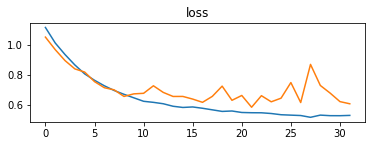

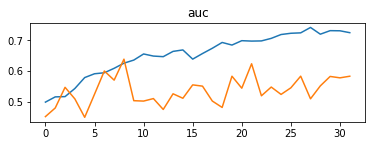

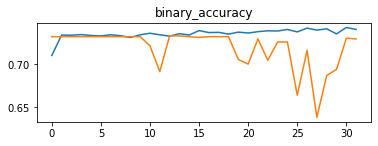

In [6]:
for i in history.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history.history[i], label='train')
  pyplot.plot(history.history['val_'+i], label='test')
  pyplot.show()


<h3 style="color:blue"> CROSS VAL 4/5 </h3>

In [2]:
col=["case","left_cc","left_mlo","right_cc","right_mlo","lb","lm","rb","rm"]
dtypes={"case": "str","left_cc": "str","left_mlo": "str","right_cc": "str","right_mlo": "str","lb": "int","lm": "int","rb": "int","rm": "int"}
df_training=pd.read_csv(directory+'/training_4.csv', sep=',', names=col,dtype=dtypes,  header=None)
df_validation=pd.read_csv(directory+'/validation_4.csv', sep=',', names=col,dtype=dtypes,  header=None)
#df_test=pd.read_csv(directory+'/test_r.csv', sep=',', names=col,dtype=dtypes,  header=None)

def read_spectograms(file_paths, img_rows, img_cols, channels):

  images = []
  
  for file_path in file_paths:
    if file_path=="nan":
        continue
    images.append(imread(file_path))
  
  images = np.asarray(images, dtype=np.float32)
  
  # normalize
  images = images / 255
  
  # reshape to match Keras expectaions
  images = images.reshape(images.shape[0], img_rows, img_cols, channels)

  return images


x_train_left_mlo = read_spectograms(df_training.left_mlo.values, img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values, img_rows, img_cols, in_channel)

###Right

x_train_right_mlo = read_spectograms(df_training.right_mlo.values, img_rows, img_cols, in_channel)
x_train_right_cc= read_spectograms(df_training.right_cc.values, img_rows, img_cols, in_channel)

###labels

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
labels = df_training[["lb","lm","rb","rm"]].reset_index(drop=True)
#labels=labels.values
labels
print(type(labels))

x_validation_left_mlo = read_spectograms(df_validation.left_mlo.values, img_rows, img_cols, in_channel)
x_validation_left_cc= read_spectograms(df_validation.left_cc.values, img_rows, img_cols, in_channel)

x_validation_right_mlo = read_spectograms(df_validation.right_mlo.values, img_rows, img_cols, in_channel)
x_validation_right_cc= read_spectograms(df_validation.right_cc.values, img_rows, img_cols, in_channel)


mlb = MultiLabelBinarizer()
labels_validation = df_validation[["lb","lm","rb","rm"]].reset_index(drop=True)
#labels_validation=labels_validation.values
labels_validation
print(type(labels_validation))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [3]:
#  V 2

def resnetBlock(inputimage,k=2,striede=1, name=""):

  batch_normalize = keras.layers.BatchNormalization( axis=-1,name="")(inputimage)


  activation=keras.activations.relu(batch_normalize )

  conv3x3_1=tf.keras.layers.Conv2D(
    filters=k,
    strides=striede,
    kernel_size=(3,3),
    name="",
  padding="same"
  )(activation)

  conv1x1_1=tf.keras.layers.Conv2D(
    filters=k,
    strides=striede,
    kernel_size=(1,1),
    name="",
#    activation=keras.activations.relu
  )(activation)


  batch_normalize_2 = keras.layers.BatchNormalization( axis=-1,name="")(conv3x3_1)

  activation2=keras.activations.relu(batch_normalize_2 )
  conv3x3_1=tf.keras.layers.Conv2D(
    filters=k,
    kernel_size=(3,3),
    name="",
    padding="same"
  )(activation2)

  outputs=keras.layers.Add()([conv3x3_1,conv1x1_1])
  return outputs


def resNetLayers(inputimage,name=""):
  block1=resnetBlock(inputimage,k=16,name="block1")
  #block2=resnetBlock(block1,k=16,name="block2")
  block3=resnetBlock(block1,k=16,striede=2,name="block3")
  #block4=resnetBlock(block3,k=32,name="block4")
  block5=resnetBlock(block3,k=32,striede=2,name="block5")
  pool=keras.layers.AveragePooling2D(
      pool_size=(3,3), strides=2, padding='same', name='' #(3,3)
  )(block5)
  #block6=resnetBlock(block5,k=32,striede=2,name="block6")
  block7=resnetBlock(pool,k=32,striede=2,name="block7")
  #block8=resnetBlock(inputfilter=128,k=128,name="block8")(block7)
  
  #block10=resnetBlock(inputfilter=256,k=256,name="block10")(block9)
  return block7

def singleViewResnet(inputimage, name=""):

  conv7x7=tf.keras.layers.Conv2D(
    filters=16,
    strides=2,
    kernel_size=(5,5),
    name="",
    activation=keras.activations.relu
  )(inputimage)

  pool3x3=keras.layers.AveragePooling2D(
      pool_size=(2,2), strides=2, padding='same', name='' #(3,3)
  )(conv7x7)

  resNetL=resNetLayers(pool3x3,name="")
  print(resNetL.shape)
  batch_normalize = keras.layers.BatchNormalization( axis=-1,name="")(resNetL)

  relu=keras.activations.relu(batch_normalize)
  
  return relu


def view_wise(img_rows=300, img_cols=300):
  left_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_cc")
  right_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_cc"
  )  

  left_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_mlo"
  )  
  right_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_mlo"
  )

  #cc_resnet=singleViewResnet(name="cc_resnet")
  #mlo_resnet=singleViewResnet(name="mlo_resnet")

  cc_resnet_left=singleViewResnet(left_cc_input)
  cc_resnet_right=singleViewResnet(right_cc_input)

  mlo_resnet_left=singleViewResnet(left_mlo_input)
  mlo_resent_right=singleViewResnet(right_mlo_input)

  avg_pool_cc_left=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(cc_resnet_left)
  avg_pool_cc_right=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(cc_resnet_right)

  avg_pool_mlo_left=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(mlo_resnet_left)
  avg_pool_mlo_right=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(mlo_resent_right)

  mlo=keras.layers.Concatenate(axis=-1)([avg_pool_mlo_left, avg_pool_mlo_right])
  cc=keras.layers.Concatenate(axis=-1)([avg_pool_cc_left, avg_pool_cc_right])

  mlo_flatten=tf.keras.layers.Flatten()(mlo)
  cc_flatten=tf.keras.layers.Flatten()(cc)

  """
  mlo_dense1=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.Dense(256,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(mlo_flatten)
    )
  """
  mlo_dense1=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(2048,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(mlo_flatten)
        )
      )
  mlo_dense3=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(1024,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(mlo_dense1)
        )
      ) 
  
  mlo_dense2=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(mlo_dense3)
    )
  
  """
  cc_dense1=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.Dense(512,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(cc_flatten)
    )
  """
  

  cc_dense1=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(2048,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(cc_flatten)
        )
      )
  cc_dense3=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(1024,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(cc_dense1)
        )
      ) 
 
  cc_dense2=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(cc_dense3)
    )
  
  
  
  """mlo_rb=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="mlo_rb")(mlo_dense2)
  mlo_rm=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="mlo_rm")(mlo_dense2)
  mlo_lb=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="mlo_lb")(mlo_dense2)
  mlo_lm=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="mlo_lm")(mlo_dense2)
  
  cc_rb=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="cc_rb")(cc_dense2)
  cc_rm=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="cc_rm")(cc_dense2)
  cc_lb=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="cc_lb")(cc_dense2)
  cc_lm=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="cc_lm")(cc_dense2)
  
  rb_output = keras.layers.Average(name="rb")([mlo_rb,cc_rb])
  rm_output = keras.layers.Average(name="rm")([mlo_rm,cc_rm])
  lb_output = keras.layers.Average(name="lb")([mlo_lb,cc_lb])
  lm_output = keras.layers.Average(name="lm")([mlo_lm,cc_lm])"""

  output=keras.layers.Average(name="outpu")([cc_dense2,mlo_dense2])

  output=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(output)
    )
  
 
  output=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(4,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(output)
    )

  return keras.Model(
      inputs=[left_cc_input, right_cc_input, left_mlo_input, right_mlo_input],
      outputs=output,name="view-wise"
  )
model=view_wise(img_rows, img_cols)
model.summary()
#keras.utils.plot_model(model, "/gdrive/My Drive/Colab_Notebooks/NNPROJECT/image_Net/view-wise.png", show_shapes=True, expand_nested=False)




(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
Model: "view-wise"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_cc (InputLayer)            [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
right_cc (InputLayer)           [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
left_mlo (InputLayer)           [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
right_mlo (InputLayer)          [(None, 512, 384, 3) 0                                            
______________________

In [4]:
batch_size=32
step_per_epoch=len(x_train_left_mlo)/batch_size

cbks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss"),
        tf.keras.callbacks.ModelCheckpoint(
                    "Z:\\Dataset\\NN_Dataset\\DDSM\\Cachelorenzo\\checkpoint_auc4",
                    monitor="val_auc",
                    mode="max",
                    verbose=1,
                    save_best_only=True,
                   
                    
                    save_freq="epoch"
                    
        ),
       tf.keras.callbacks.ModelCheckpoint(
                    "Z:\\Dataset\\NN_Dataset\\DDSM\\Cachelorenzo\\checkpoint_loss4",
                    monitor="val_loss",
                    
                    verbose=1,
                    save_best_only=True,
                   
                    
                    save_freq="epoch"
       )]


model.compile(#optimizer=keras.optimizers.Adam(lr=0.001),
              #optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07),
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history=model.fit(x={"left_mlo": x_train_left_mlo,
                         "left_cc": x_train_left_cc,
                         "right_mlo":x_train_right_mlo,
                         "right_cc":x_train_right_cc},
                  y=labels.values,
                  epochs=50,verbose=1,
                  callbacks=cbks,
                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "left_cc": x_validation_left_cc,
                         "right_mlo":x_validation_right_mlo,
                         "right_cc":x_validation_right_cc},
                    labels_validation.values
                  ))

"""y={"lb":labels["lb"],
    "lm":labels["lm"],
    "rm":labels["rm"],
    "rb":labels["rb"]}
    
"""

Train on 1036 samples, validate on 210 samples
Epoch 1/50
1024/1036 [============================>.] - ETA: 0s - loss: 1.1054 - auc: 0.5145 - binary_accuracy: 0.7085
Epoch 00001: val_auc improved from -inf to 0.51036, saving model to Z:\Dataset\NN_Dataset\DDSM\Cachelorenzo\checkpoint_auc4
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Z:\Dataset\NN_Dataset\DDSM\Cachelorenzo\checkpoint_auc4\assets

Epoch 00001: val_loss improved from inf to 1.04044, saving model to Z:\Dataset\NN_Dataset\DDSM\Cachelorenzo\checkpoint_loss4
INFO:tensorflow:Assets written to: Z:\Dataset\NN_Dataset\DDSM\Cachelorenzo\checkpoint_loss4\assets
1036/1036 [==============================] - 82s 79ms/sample - loss: 1.1044 - auc: 0.5156 - binary_accuracy: 0.7090 - val_loss: 1.0404 - val_auc: 0.5104 - val_binary_accuracy: 0.7345
Epoch 2/50
1024/1036 [============================>.] - ETA: 0s - loss: 0.9776 - auc: 0.6333 - binary_accuracy: 0.7336
Epoc

'y={"lb":labels["lb"],\n    "lm":labels["lm"],\n    "rm":labels["rm"],\n    "rb":labels["rb"]}\n    \n'

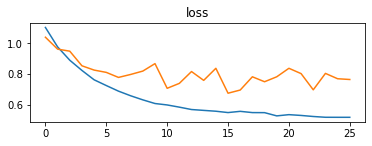

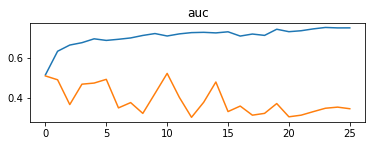

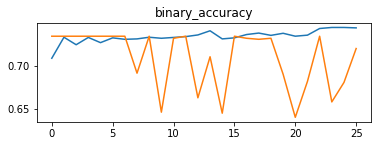

In [6]:
for i in history.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history.history[i], label='train')
  pyplot.plot(history.history['val_'+i], label='test')
  pyplot.show()


<h3 style="color:blue"> CROSS VAL 5/5 </h3>

In [2]:
col=["case","left_cc","left_mlo","right_cc","right_mlo","lb","lm","rb","rm"]
dtypes={"case": "str","left_cc": "str","left_mlo": "str","right_cc": "str","right_mlo": "str","lb": "int","lm": "int","rb": "int","rm": "int"}
df_training=pd.read_csv(directory+'/training_5.csv', sep=',', names=col,dtype=dtypes,  header=None)
df_validation=pd.read_csv(directory+'/validation_5.csv', sep=',', names=col,dtype=dtypes,  header=None)
#df_test=pd.read_csv(directory+'/test_r.csv', sep=',', names=col,dtype=dtypes,  header=None)

def read_spectograms(file_paths, img_rows, img_cols, channels):

  images = []
  
  for file_path in file_paths:
    if file_path=="nan":
        continue
    images.append(imread(file_path))
  
  images = np.asarray(images, dtype=np.float32)
  
  # normalize
  images = images / 255
  
  # reshape to match Keras expectaions
  images = images.reshape(images.shape[0], img_rows, img_cols, channels)

  return images


x_train_left_mlo = read_spectograms(df_training.left_mlo.values, img_rows, img_cols, in_channel)
x_train_left_cc= read_spectograms(df_training.left_cc.values, img_rows, img_cols, in_channel)

###Right

x_train_right_mlo = read_spectograms(df_training.right_mlo.values, img_rows, img_cols, in_channel)
x_train_right_cc= read_spectograms(df_training.right_cc.values, img_rows, img_cols, in_channel)

###labels

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
labels = df_training[["lb","lm","rb","rm"]].reset_index(drop=True)
#labels=labels.values
labels
print(type(labels))

x_validation_left_mlo = read_spectograms(df_validation.left_mlo.values, img_rows, img_cols, in_channel)
x_validation_left_cc= read_spectograms(df_validation.left_cc.values, img_rows, img_cols, in_channel)

x_validation_right_mlo = read_spectograms(df_validation.right_mlo.values, img_rows, img_cols, in_channel)
x_validation_right_cc= read_spectograms(df_validation.right_cc.values, img_rows, img_cols, in_channel)


mlb = MultiLabelBinarizer()
labels_validation = df_validation[["lb","lm","rb","rm"]].reset_index(drop=True)
#labels_validation=labels_validation.values
labels_validation
print(type(labels_validation))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [3]:
#  V 2

def resnetBlock(inputimage,k=2,striede=1, name=""):

  batch_normalize = keras.layers.BatchNormalization( axis=-1,name="")(inputimage)


  activation=keras.activations.relu(batch_normalize )

  conv3x3_1=tf.keras.layers.Conv2D(
    filters=k,
    strides=striede,
    kernel_size=(3,3),
    name="",
  padding="same"
  )(activation)

  conv1x1_1=tf.keras.layers.Conv2D(
    filters=k,
    strides=striede,
    kernel_size=(1,1),
    name="",
#    activation=keras.activations.relu
  )(activation)


  batch_normalize_2 = keras.layers.BatchNormalization( axis=-1,name="")(conv3x3_1)

  activation2=keras.activations.relu(batch_normalize_2 )
  conv3x3_1=tf.keras.layers.Conv2D(
    filters=k,
    kernel_size=(3,3),
    name="",
    padding="same"
  )(activation2)

  outputs=keras.layers.Add()([conv3x3_1,conv1x1_1])
  return outputs


def resNetLayers(inputimage,name=""):
  block1=resnetBlock(inputimage,k=16,name="block1")
  #block2=resnetBlock(block1,k=16,name="block2")
  block3=resnetBlock(block1,k=16,striede=2,name="block3")
  #block4=resnetBlock(block3,k=32,name="block4")
  block5=resnetBlock(block3,k=32,striede=2,name="block5")
  pool=keras.layers.AveragePooling2D(
      pool_size=(3,3), strides=2, padding='same', name='' #(3,3)
  )(block5)
  #block6=resnetBlock(block5,k=32,striede=2,name="block6")
  block7=resnetBlock(pool,k=32,striede=2,name="block7")
  #block8=resnetBlock(inputfilter=128,k=128,name="block8")(block7)
  
  #block10=resnetBlock(inputfilter=256,k=256,name="block10")(block9)
  return block7

def singleViewResnet(inputimage, name=""):

  conv7x7=tf.keras.layers.Conv2D(
    filters=16,
    strides=2,
    kernel_size=(5,5),
    name="",
    activation=keras.activations.relu
  )(inputimage)

  pool3x3=keras.layers.AveragePooling2D(
      pool_size=(2,2), strides=2, padding='same', name='' #(3,3)
  )(conv7x7)

  resNetL=resNetLayers(pool3x3,name="")
  print(resNetL.shape)
  batch_normalize = keras.layers.BatchNormalization( axis=-1,name="")(resNetL)

  relu=keras.activations.relu(batch_normalize)
  
  return relu


def view_wise(img_rows=300, img_cols=300):
  left_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_cc")
  right_cc_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_cc"
  )  

  left_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="left_mlo"
  )  
  right_mlo_input = keras.Input(
      shape=(img_rows, img_cols, 3), name="right_mlo"
  )

  #cc_resnet=singleViewResnet(name="cc_resnet")
  #mlo_resnet=singleViewResnet(name="mlo_resnet")

  cc_resnet_left=singleViewResnet(left_cc_input)
  cc_resnet_right=singleViewResnet(right_cc_input)

  mlo_resnet_left=singleViewResnet(left_mlo_input)
  mlo_resent_right=singleViewResnet(right_mlo_input)

  avg_pool_cc_left=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(cc_resnet_left)
  avg_pool_cc_right=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(cc_resnet_right)

  avg_pool_mlo_left=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(mlo_resnet_left)
  avg_pool_mlo_right=tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), padding='same')(mlo_resent_right)

  mlo=keras.layers.Concatenate(axis=-1)([avg_pool_mlo_left, avg_pool_mlo_right])
  cc=keras.layers.Concatenate(axis=-1)([avg_pool_cc_left, avg_pool_cc_right])

  mlo_flatten=tf.keras.layers.Flatten()(mlo)
  cc_flatten=tf.keras.layers.Flatten()(cc)

  """
  mlo_dense1=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.Dense(256,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(mlo_flatten)
    )
  """
  mlo_dense1=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(2048,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(mlo_flatten)
        )
      )
  mlo_dense3=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(1024,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(mlo_dense1)
        )
      ) 
  
  mlo_dense2=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(mlo_dense3)
    )
  
  """
  cc_dense1=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.Dense(512,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(cc_flatten)
    )
  """
  

  cc_dense1=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(2048,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(cc_flatten)
        )
      )
  cc_dense3=tf.keras.layers.Dropout(.2)(
      tf.keras.layers.LeakyReLU(alpha=0.1)(
          tf.keras.layers.Dense(1024,
          kernel_regularizer=tf.keras.regularizers.l2(regl2))(cc_dense1)
        )
      ) 
 
  cc_dense2=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(cc_dense3)
    )
  
  
  
  """mlo_rb=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="mlo_rb")(mlo_dense2)
  mlo_rm=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="mlo_rm")(mlo_dense2)
  mlo_lb=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="mlo_lb")(mlo_dense2)
  mlo_lm=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="mlo_lm")(mlo_dense2)
  
  cc_rb=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="cc_rb")(cc_dense2)
  cc_rm=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="cc_rm")(cc_dense2)
  cc_lb=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="cc_lb")(cc_dense2)
  cc_lm=tf.keras.layers.Dense(1, activation='sigmoid',
                                    kernel_regularizer=tf.keras.regularizers.l2(regl2),name="cc_lm")(cc_dense2)
  
  rb_output = keras.layers.Average(name="rb")([mlo_rb,cc_rb])
  rm_output = keras.layers.Average(name="rm")([mlo_rm,cc_rm])
  lb_output = keras.layers.Average(name="lb")([mlo_lb,cc_lb])
  lm_output = keras.layers.Average(name="lm")([mlo_lm,cc_lm])"""

  output=keras.layers.Average(name="outpu")([cc_dense2,mlo_dense2])

  output=tf.keras.layers.Dropout(.3)(
      tf.keras.layers.Dense(64,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="relu")(output)
    )
  
 
  output=tf.keras.layers.Dropout(.0)(
      tf.keras.layers.Dense(4,
      kernel_regularizer=tf.keras.regularizers.l2(regl2),activation="sigmoid")(output)
    )

  return keras.Model(
      inputs=[left_cc_input, right_cc_input, left_mlo_input, right_mlo_input],
      outputs=output,name="view-wise"
  )
model=view_wise(img_rows, img_cols)
model.summary()
#keras.utils.plot_model(model, "/gdrive/My Drive/Colab_Notebooks/NNPROJECT/image_Net/view-wise.png", show_shapes=True, expand_nested=False)




(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
(None, 8, 6, 32)
Model: "view-wise"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_cc (InputLayer)            [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
right_cc (InputLayer)           [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
left_mlo (InputLayer)           [(None, 512, 384, 3) 0                                            
__________________________________________________________________________________________________
right_mlo (InputLayer)          [(None, 512, 384, 3) 0                                            
______________________

In [4]:
batch_size=32
step_per_epoch=len(x_train_left_mlo)/batch_size


cbks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss"),
        tf.keras.callbacks.ModelCheckpoint(
                    "Z:\\Dataset\\NN_Dataset\\DDSM\\Cachelorenzo\\checkpoint_auc5",
                    monitor="val_auc",
                    mode="max",
                    verbose=1,
                    save_best_only=True,
                   
                    
                    save_freq="epoch"
                    
        ),
       tf.keras.callbacks.ModelCheckpoint(
                    "Z:\\Dataset\\NN_Dataset\\DDSM\\Cachelorenzo\\checkpoint_loss5",
                    monitor="val_loss",
                    
                    verbose=1,
                    save_best_only=True,
                   
                    
                    save_freq="epoch"
       )]

model.compile(#optimizer=keras.optimizers.Adam(lr=0.001),
              #optimizer=keras.optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,rho=0.9,momentum=0.9,epsilon=1e-07),
              loss=keras.losses.BinaryCrossentropy(),
              #loss=custom_loss,
              metrics=[tf.keras.metrics.AUC(name="auc"),tf.keras.metrics.BinaryAccuracy(threshold=0.5)]#tf.keras.metrics.BinaryAccuracy(threshold=0.01)]#,
             )

history=model.fit(x={"left_mlo": x_train_left_mlo,
                         "left_cc": x_train_left_cc,
                         "right_mlo":x_train_right_mlo,
                         "right_cc":x_train_right_cc},
                  y=labels.values,
                  epochs=50,verbose=1,
                  callbacks = cbks,
                  validation_data=(
                      {"left_mlo": x_validation_left_mlo,
                         "left_cc": x_validation_left_cc,
                         "right_mlo":x_validation_right_mlo,
                         "right_cc":x_validation_right_cc},
                    labels_validation.values
                  ))

"""y={"lb":labels["lb"],
    "lm":labels["lm"],
    "rm":labels["rm"],
    "rb":labels["rb"]}
    
"""

Train on 997 samples, validate on 249 samples
Epoch 1/50
992/997 [============================>.] - ETA: 0s - loss: 1.0952 - auc: 0.5345 - binary_accuracy: 0.7243
Epoch 00001: val_auc improved from -inf to 0.50926, saving model to Z:\Dataset\NN_Dataset\DDSM\Cachelorenzo\checkpoint_auc5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Z:\Dataset\NN_Dataset\DDSM\Cachelorenzo\checkpoint_auc5\assets

Epoch 00001: val_loss improved from inf to 1.04015, saving model to Z:\Dataset\NN_Dataset\DDSM\Cachelorenzo\checkpoint_loss5
INFO:tensorflow:Assets written to: Z:\Dataset\NN_Dataset\DDSM\Cachelorenzo\checkpoint_loss5\assets
997/997 [==============================] - 92s 92ms/sample - loss: 1.0950 - auc: 0.5348 - binary_accuracy: 0.7244 - val_loss: 1.0402 - val_auc: 0.5093 - val_binary_accuracy: 0.7400
Epoch 2/50
992/997 [============================>.] - ETA: 0s - loss: 0.9949 - auc: 0.6026 - binary_accuracy: 0.7271
Epoch 00002

'y={"lb":labels["lb"],\n    "lm":labels["lm"],\n    "rm":labels["rm"],\n    "rb":labels["rb"]}\n    \n'

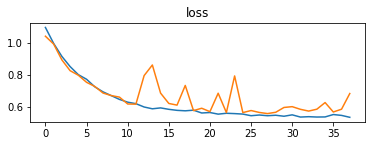

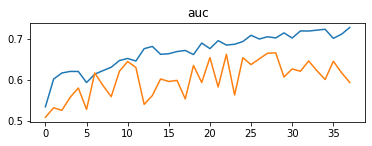

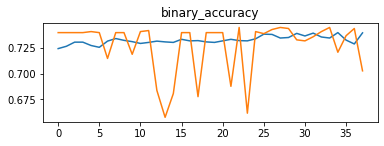

In [5]:
for i in history.history.keys():
  if "val" in i:
    continue
  # plot loss during training
  pyplot.subplot(211)
  pyplot.title(i)
  pyplot.plot(history.history[i], label='train')
  pyplot.plot(history.history['val_'+i], label='test')
  pyplot.show()


<h2> Writing CSV (1-5)</h2>

In [30]:
with open(directory+'/training_5.csv', 'w', newline='') as file:

  writer = csv.writer(file)

  for number in numbers1:
    for folder in folders:
      for i,j,y in os.walk(directory2+folder+number,topdown=False):
        
        if(j):
          for name in j:
            left_cc=""
            left_mlo=""
            right_cc=""
            right_mlo=""
            lb="0"
            rb="0"
            lm="0"
            rm="0"
            case=name
            for i2,j2,y2 in os.walk(i+name,topdown=False):
              for name2 in y2:
                if "LEFT_CC.png" in name2:
                  left_cc=i2+"/"+name2
                if "LEFT_MLO.png" in name2:
                  left_mlo=i2+"/"+name2
                if "RIGHT_CC.png" in name2:
                  right_cc= i2+"/"+name2
                if "RIGHT_MLO.png" in name2:
                  right_mlo=i2+"/"+name2

                if "benign" in folder:
                  if name2.endswith(".OVERLAY"):
                    if "LEFT" in name2:
                      lb="1"
                    if "RIGHT" in name2:
                      rb="1"
                if "cancer" in folder:
                  if name2.endswith(".OVERLAY"):
                    if "LEFT" in name2:
                      lm="1"
                    if "RIGHT" in name2:
                      rm="1"
            if(left_cc!="" and right_cc!="" and right_mlo!="" and left_mlo!=""):
                writer.writerow([case,left_cc,left_mlo,right_cc,right_mlo,lb,lm,rb,rm])
              

In [31]:
with open(directory+'/validation_5.csv', 'w', newline='') as file:

  writer = csv.writer(file)

  for folder in folders:
    for number in numbers2:
      for i,j,y in os.walk(directory2+folder+number,topdown=False):
        
        if(j):
          for name in j:
            left_cc=""
            left_mlo=""
            right_cc=""
            right_mlo=""
            lb="0"
            rb="0"
            
            lm="0"
            rm="0"
            case=name
            for i2,j2,y2 in os.walk(i+name,topdown=False):
              for name2 in y2:
                if "LEFT_CC.png" in name2:
                  left_cc=i2+"/"+name2
                if "LEFT_MLO.png" in name2:
                  left_mlo=i2+"/"+name2
                if "RIGHT_CC.png" in name2:
                  right_cc= i2+"/"+name2
                if "RIGHT_MLO.png" in name2:
                  right_mlo=i2+"/"+name2

                if "benign" in folder:
                  if name2.endswith(".OVERLAY"):
                    if "LEFT" in name2:
                      lb="1"
                    if "RIGHT" in name2:
                      rb="1"
                if "cancer" in folder:
                  if name2.endswith(".OVERLAY"):
                    if "LEFT" in name2:
                      lm="1"
                    if "RIGHT" in name2:
                      rm="1"
            if(left_cc!="" and right_cc!="" and right_mlo!="" and left_mlo!=""):
                writer.writerow([case,left_cc,left_mlo,right_cc,right_mlo,lb,lm,rb,rm])
